# Regularization and Support Vector Regression

Based on https://www.nbshare.io/notebook/819279082/Regularization-Techniques-in-Linear-Regression-With-Python and https://github.com/tomsharp/SVR/blob/master/SVR.ipynb


## Overview

In machine learning we use data to approximate a model that is flexible enough to fit such data. Larger flexibility results in a model closer on average to the trainin set, with low bias but large variance. In those situations we need to control and prevent overfitting to the data set. We do this through a concept known as regularization. We will analize common regularization methods and their appication in vector support regression.

# Libraries

In [1]:
import numpy  as np

import matplotlib.pyplot as plt

from matplotlib              import cm

from sklearn                 import svm
from sklearn                 import datasets
from sklearn.svm             import LinearSVR
from sklearn.linear_model    import LinearRegression
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.linear_model    import ElasticNet, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics         import mean_squared_error
from sklearn.metrics         import mean_absolute_error

# Ignore warnings about convergence
import warnings
warnings.filterwarnings('ignore')

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

blue   = '#0021A5'
orange = '#FA4616'

## 1. Regularization

Regularization is used to constrain (or regularize) the estimated coefficients of a model. This protects the model from overfitting on the training data. In the previous notebook on cross-validation we showed that overfitting of a polynomial regression can lead to poor prediction accuracy. Cross-validation is one approach to reduce overfitting. In that example, we used cross-validation to determine the optimal order of the polynomial for fitting the data.

Regularization lets us include more features into a model while avoiding to overfit through constraints of the optimized model coefficients. In other words, regularization is used to prevent overfitting but too much regularization can result in underfitting.

A common approach of regularization is to shrink the model coefficients towards zero. We apply such a regularization constraint, we by simply adding a term to our loss function that measures the deviation of the model coefficients from zero.

1. LASSO regularization (absolute values of coefficients)
$$
C_\mathrm{LASSO} = C({\bf X}, {\bf y}, \beta) + \lambda \sum_{j=1}^k | \beta_j |.
$$

2. Ridge regularization (squared coefficients)
$$
C_\mathrm{Ridge} = C({\bf X}, {\bf y}, \beta) + \lambda \sum_{j=1}^k \beta_j^2.
$$


3. ElasticNet regularization (linear combination of absolute values and squared coefficients)
$$
C_\mathrm{ElasticNet} = C({\bf X}, {\bf y}, \beta) + \lambda \sum_{j=1}^k \left ( | \beta_j | + \beta_j^2 \right ).
$$

The variable $\lambda$ is a hyperparameter to control the strength of our regularization. If $\lambda = 0$, we end up with linear regression with the usual loss function. If  $\lambda = \infty$, the regularization term would would dwarf the original loss function and drive all the coefficients to zero in the parameter optimization. Hence, a large λ results in underfitting.

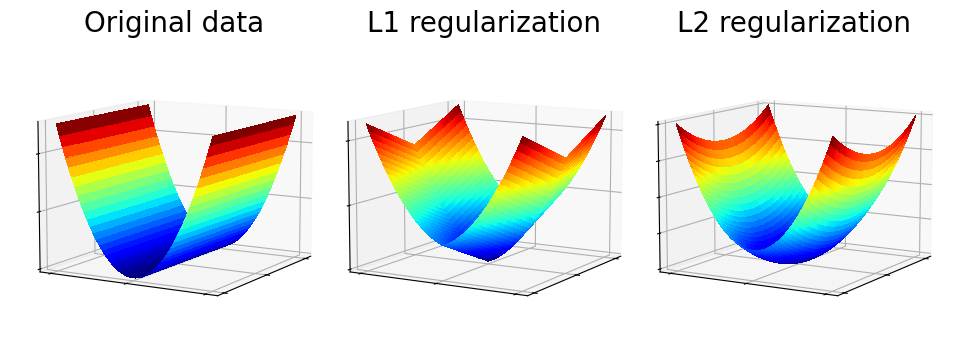

In [2]:
# Create a function to plot the data
def plot_3d(subplot, title):

    ax = fig.add_subplot(1, 3, subplot, projection='3d')
    fig.subplots_adjust(wspace=0, hspace=0)

    ax.plot_surface(X1, X2, Y, cmap=cm.jet,
                    antialiased=False)
    
    ax.set_title(title, fontsize=20)
    
    ax.view_init(elev=10, azim=30)

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

# Create a regular 2d mesh
points = np.linspace(-5.0, 5.0, num=200)

X1, X2 = np.meshgrid(points, points)

fig    = plt.figure(figsize=(12,8))

# Plot original data
Y = 0.1*(X2*X2)
plot_3d(1, 'Original data')

# Plot L1 LASSO regularization
Y = 0.1*(X2*X2) + 0.2*( np.abs(X1) + np.abs(X2) )
plot_3d(2, 'L1 regularization')

# Plot L2 Ridge regularization 
Y = 0.1*(X2*X2) + 0.03*(X1*X1 + X2*X2)
plot_3d(3, 'L2 regularization')

- The original data is constructured such that is has a valley along which the cost function does not change. This is also called soft degree of freedom, which can occur when the data does not constrain all model parameters equally well. These poorly constrained parameters can lead to a large variance in the prediction error on the validation set.

- The $L_1$ and $L_2$ regularization turn this valley in to minimum. For $L_1$ regularization, the minimum becomes a sharp point due to the use of the absolute value.

- The $L_2$ regularization leads to a quadratic mimimum, that can be found analytically in linear regression. For the likelihood, which is the negative of the cost function, the original data shows a ridge. The $L_2$ regularization turns that ridge into a nice peak in likelihood space, equivalent to a quadratic depression in the cost function.

### 1.2 Feature Scaling

The various features in our data set may not be on the same scale. In that case, the model  coefficients are not going to be on the same scale either, resulting in different regularization on the various coefficients. Therefore, we need to normalize all the data to be on the same scale. This step is called feature scaling or data normalization.

#### 1.2.1 Example for Linear Regression

Let's generate a small data set to analize the behavior of these regularization methods

In [3]:
def plot_errors(lambdas, train_errors, test_errors, title, inset_kwargs=None):

    fig, ax = plt.subplots( figsize=(12, 8) )

    ax.set_title(title, fontsize=20)

    ax.set_xlabel(r'$\lambda$', fontsize=18)
    ax.set_ylabel('MSE', fontsize=18)

    ax.plot(lambdas, train_errors, lw=4, color=blue,   label='Training')
    ax.plot(lambdas, test_errors,  lw=4, color=orange, label='Testing')
    
    ax.legend(fontsize=18)

    if inset_kwargs:
        inset = ax.inset_axes( [inset_kwargs['x0'],
                                inset_kwargs['y0'],
                                inset_kwargs['width'],
                                inset_kwargs['height']] )

        inset.plot(inset_kwargs['lambdas'],
                   inset_kwargs['train_errors'],
                   lw=4, color=blue,   label='Training')
        
        inset.plot(inset_kwargs['lambdas'],
                   inset_kwargs['test_errors'], 
                   lw=4, color=orange, label='Testing')

        ax.indicate_inset_zoom(inset, edgecolor='black')

    plt.show()

In [4]:
# NOTE: In sklearn, they refer to lambda as alpha, the name is different in different literature

def evaluate_model(Model, lambdas, x_train=None, y_train=None, x_test=None, y_test=None):

    training_errors = []
    testing_errors  = []

    for lambda_value in lambdas:
        
        model = Model(alpha=lambda_value, max_iter=1000) # Lasso, Ridge or ElasticNet
        model.fit(x_train, y_train)

        training_predictions = model.predict(x_train)

        training_mse = mean_squared_error(y_train, training_predictions)
        training_errors.append(training_mse)

        testing_predictions = model.predict(x_test)

        testing_mse  = mean_squared_error(y_test, testing_predictions)
        testing_errors.append(testing_mse)

    return training_errors, testing_errors

In [5]:
# Generate a data set for machine learning
np.random.seed(seed=5)

x = np.linspace(0.0, 2.0, num=150)
x = x + np.random.normal(0.0, 0.3, x.shape)

y = np.cos(x) + 2.0*np.sin(x) + 3.0*np.cos(2.0*x) + np.random.normal(0.0, 1.0, x.shape)

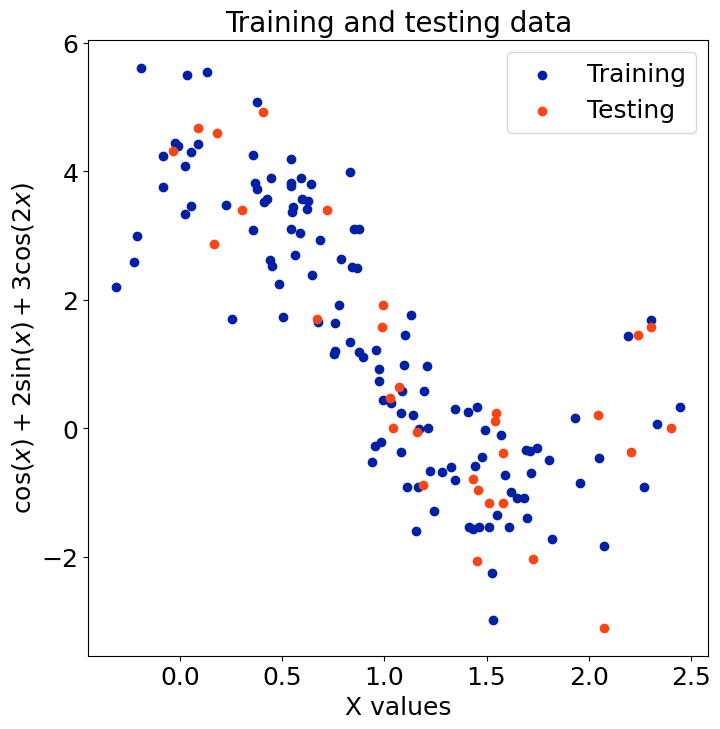

In [6]:
# Split the dataset into 80% for training and 20% for testing
x = x.reshape( (-1,1) )

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, shuffle=True)

# Plot the training and testing dataset
fig,ax=plt.subplots( figsize=(8,8) )

ax.scatter(x_train, y_train, color=blue,   label='Training')
ax.scatter(x_test, y_test,   color=orange, label='Testing')

ax.set_title('Training and testing data', fontsize=20)

ax.set_xlabel('X values', fontsize=18)
ax.set_ylabel(r'$\cos(x)+2\sin(x)+3\cos(2x)$', fontsize=18)

plt.legend(fontsize=18)

plt.show()

# Create the polynomial features for a large degree for the polynomials
degree  = 20

X_train = PolynomialFeatures(degree).fit_transform(x_train)
X_test  = PolynomialFeatures(degree).fit_transform(x_test)

#### 1.2.2 Lasso $L^1$ Regularization
$$
C_\mathrm{LASSO} = C({\bf X}, {\bf y}, \beta) + \lambda \sum_{j=1}^k | \beta_j |.
$$

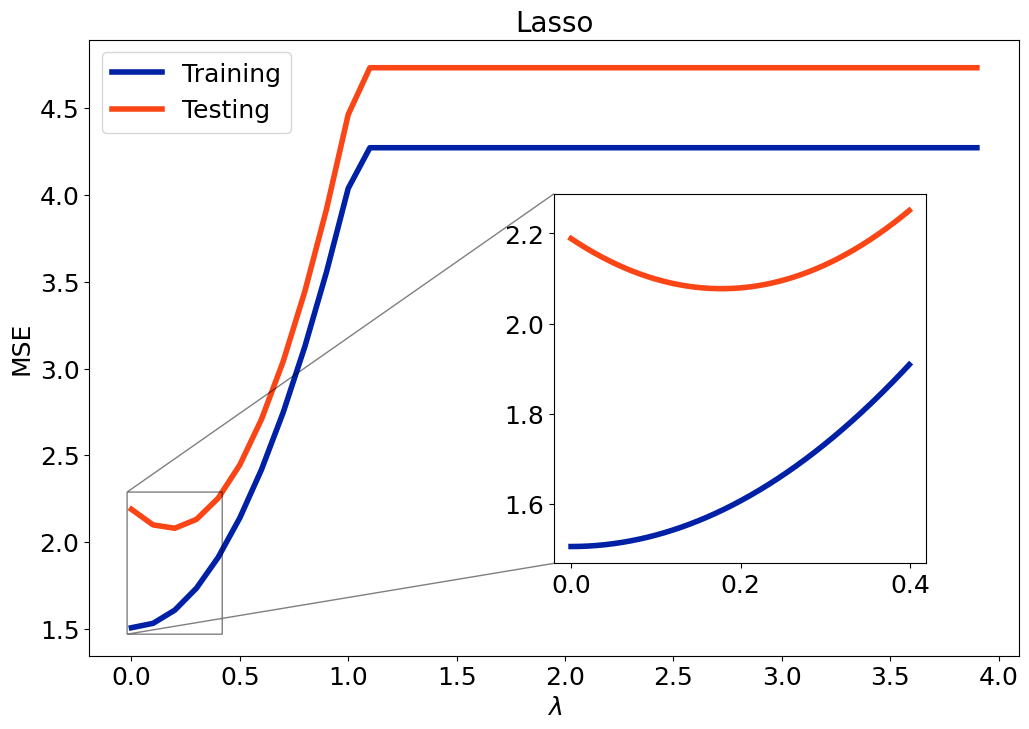

In [7]:
# Generate range of values for a smaller range of lambda
lambdas = np.arange(0.0, 0.4, step=0.001)

train, test = evaluate_model(Lasso, lambdas,
                             x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

inset_kwargs = {'lambdas'     : lambdas,
                'train_errors': train,
                'test_errors' : test,
                'x0'          : 0.5,
                'y0'          : 0.15,
                'width'       : 0.4,
                'height'      : 0.6}

# Generate range of values for lambda from 0 (no-regularization) and (4 too much regularization)
lambdas = np.arange(0.0, 4.0, step=0.1)

train, test = evaluate_model(Lasso, lambdas,
                             x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

plot_errors(lambdas, train, test, 'Lasso', inset_kwargs=inset_kwargs)

The inset shows an inflection between training and testing, indicating that for the $C_\mathrm{LASSO}$ regularization, the optimal value of $\lambda$ is about 0.2 for this dataset.

### Assignment

- Explore what happens to the dependence of the MSE on $\lambda$ for a smaller and larger dataset?
   - Change the value of num in `x = np.linspace(0.0, 2.0, num=150)`.
   - I suggest changing the number of datapoints by about a factor of two.

- In which case does regularization become more important and when do not require regularization?

#### 1.2.3 Ridge Regression

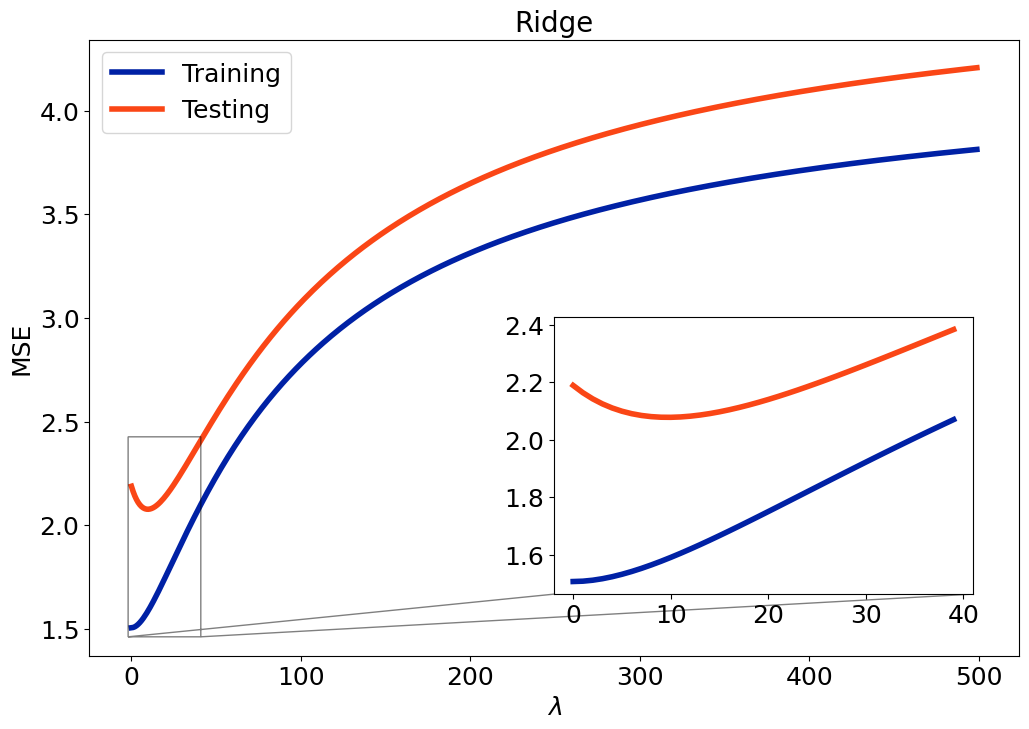

In [8]:
# Generate range of values for a smaller range of lambda
lambdas = np.arange(0.0, 40.0, step=1.0)

train, test = evaluate_model(Ridge, lambdas,
                             x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

inset_kwargs = {'lambdas'     : lambdas,
                'train_errors': train,
                'test_errors' : test,
                'x0'          : 0.50,
                'y0'          : 0.10,
                'width'       : 0.45,
                'height'      : 0.45}

# let's generate different values for lambda from 0 (no-regularization) and (10 too much regularization)
lambdas = np.arange(0.0, 500.0, step=1.0)

train, test = evaluate_model(Ridge, lambdas,
                             x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

plot_errors(lambdas, train, test, 'Ridge', inset_kwargs=inset_kwargs)

We can see an analogous effect for the $C_\mathrm{Ridge}$ regularization. But notice that for this method, the inflection occurs for $\lambda \approx 30$.

#### 1.2.4 Elastic Net

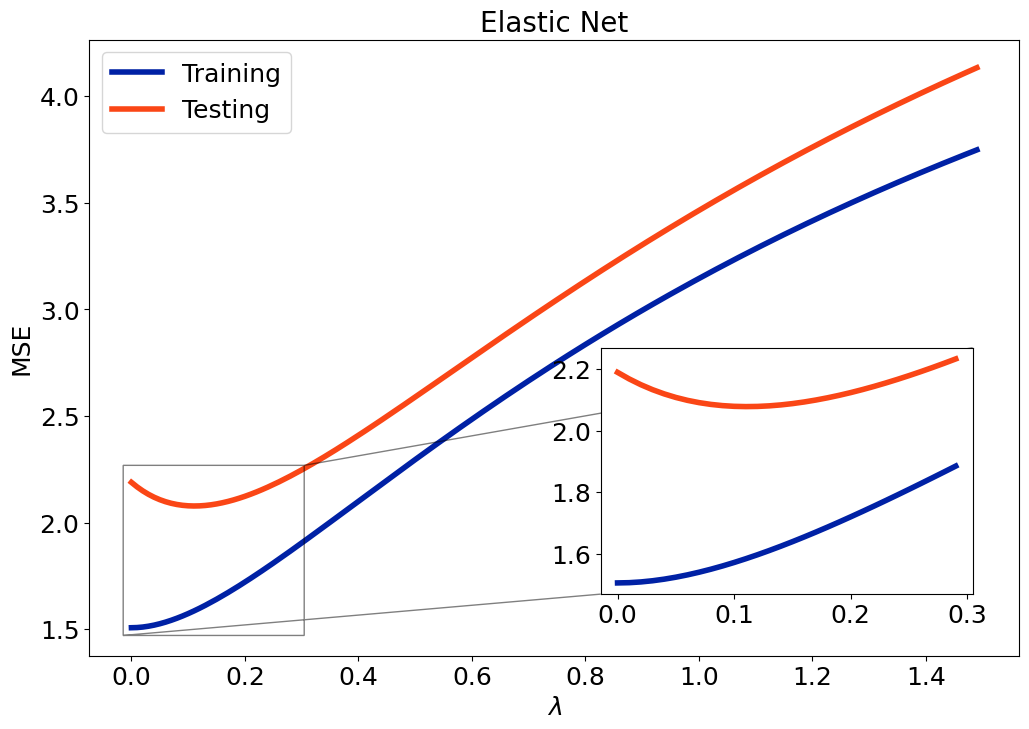

In [9]:
# Generate range of values for a smaller range of lambda
lambdas = np.arange(0, 0.3, step=0.01)

train, test = evaluate_model(ElasticNet, lambdas,
                             x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

inset_kwargs = {'lambdas'     : lambdas,
                'train_errors': train,
                'test_errors' : test,
                'x0'          : 0.55,
                'y0'          : 0.10,
                'width'       : 0.40,
                'height'      : 0.40}

# Generate a range of values for lambda from 0 (no-regularization) to a larger value with probably too much regularization
lambdas = np.arange(0, 1.5, step=0.01)

train, test = evaluate_model(ElasticNet, lambdas,
                             x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

plot_errors(lambdas, train, test, 'Elastic Net', inset_kwargs=inset_kwargs)

Finally, for the $C_\mathrm{Elastic Net}$ regularization this point is located at $\lambda \approx 0.2$.

### 1.3 Regularization Techniques Comparison
- Lasso: will eliminate many features, and reduce overfitting in your linear model.
- Ridge: will reduce the impact of features that are not important in predicting your y values.
- Elastic Net: combines feature elimination from Lasso and feature coefficient reduction from the Ridge model to improve your model’s predictions.

### 1.4 Cross Validation and Regularization 

The relationship between the training error / test error versus the model complexity has a U-shaped form. When learning a model, we have two goals:

1. Find the optimum on the model complexity axis where the U curve starts to go up again. This happens for the test error curve, even though the training error curve continues to go down overfitting the training data in high-complexity models.

2. Reduce the gap between the training error and test error curve.

Goal (1) is achieved by using cross validation, finding the fine balance between bias and variance.

Goal (2) is achieved by using regularization, raising the training error curve to be closer to the test error.

## 2. Support Vector Regression

- SVR minimizes the $L_2$ norm of the coefficient vector, not the squared error.

- The error term is instead handled in the constraints, where we set the absolute error less than or equal to a specified maximum error, $\epsilon$.

- For any data point that falls outside of $\epsilon$, we can denote its deviation from the margin by a slack variable $\xi$:
$$
\vert y_i - {\bf x}_i\, \beta \vert \le \epsilon + \vert \xi_i \vert
$$

- We minimize the $L_2$ norm of the coefficient vector and these deviations ising an additional hyperparameter $C$:
$$
\min \frac{1}{2} \| \beta \|^2 + C \sum_{i=1}^n \vert \xi_i \vert^2
$$

In order to illustrate the support vector regression, let's create a noisy linear dataset

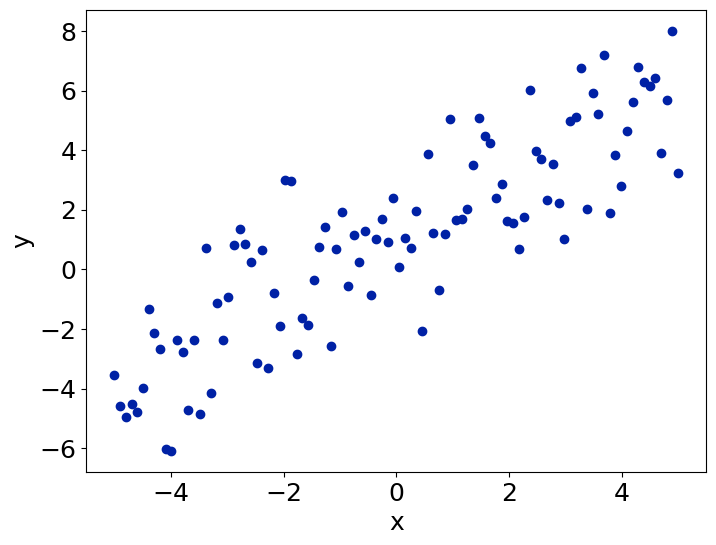

In [10]:
# Initialize random seed
np.random.seed(19)

# Create a linear dataset
points = 100

x = np.linspace(-5.0, 5.0, num=points, endpoint=True)
y = x + 1.0 + np.random.normal(0.0, 2.0, points)

# Create list with 2 points in interval x:[-5,5]
x_pred = np.linspace(-5.0, 5.0, num=2, endpoint=True)

X = x.reshape(-1,1)
y = y.reshape(-1,1)

X_pred = x_pred.reshape(-1,1)

# Set axes and labels
fig = plt.figure( figsize = (8,6) )

ax = fig.add_subplot()

ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)

plt.scatter(x, y, color=blue)

plt.show()

### 2.1 Linear Regression

First we start with our well-know linear regression.

> Split the dataset into 80% for training and 20% for testing. Create the plot and report
> - Mean Absolute Deviation between regression and reference data,
> - Intercept coefficient for the linear regression, and
> - Slope for the linear regression.

### 2.2 Support Vector Regression

We can define a function to help us plot results more efficiently

In [11]:
def svr_results(y_test, X_test, model, epsilon=0.0):
    
    test_mae = mean_absolute_error(y_test, model.predict(X_test))

    within_epsilon            = np.sum( np.abs(y_test - model.predict(X_test)) <= epsilon )
    percentage_within_epsilon = 100.0*within_epsilon/y_test.size
    
    # Plot outputs
    plt.figure(figsize=(12,8))

    plt.scatter(x, y, color=blue)

    plt.plot(X_pred, model.predict(X_pred),           color=orange, lw=4)
    plt.plot(X_pred, model.predict(X_pred) + epsilon, color='g', ls='dashed', lw=4)
    plt.plot(X_pred, model.predict(X_pred) - epsilon, color='g', ls='dashed', lw=4)

    plt.title('SVR Prediction', fontsize=20)

    plt.xlabel('x', fontsize=18)
    plt.ylabel('y', fontsize=18)
    
    plt.annotate(f'Slope = {model.coef_[0]:.4f}',
                 xy=(0.05,0.9), xycoords='axes fraction', fontsize=18)

    plt.annotate(f'Intercept = {model.intercept_[0]:.4f}',
                 xy=(0.05,0.85), xycoords='axes fraction', fontsize=18)

    plt.annotate(f'MAE = {test_mae:.4f}',
                 xy=(0.05,0.8), xycoords='axes fraction', fontsize=18)

    plt.annotate(r'Percentage within $\epsilon$ = {:.1f}'.format(percentage_within_epsilon),
                 xy=(0.05,0.75), xycoords='axes fraction', fontsize=18)

    plt.annotate(r'$\epsilon$ = {:.4f}'.format(epsilon),
                 xy=(0.65,0.2), xycoords='axes fraction', fontsize=18)

    plt.annotate(r'$C$ = {:.4f}'.format(model.C),
                 xy=(0.65,0.15), xycoords='axes fraction', fontsize=18)
    
    plt.show()

First, let's use a small hyperparameter $C$ for the constraint on the slack variables.

ValueError: X has 1 features, but LinearSVR is expecting 21 features as input.

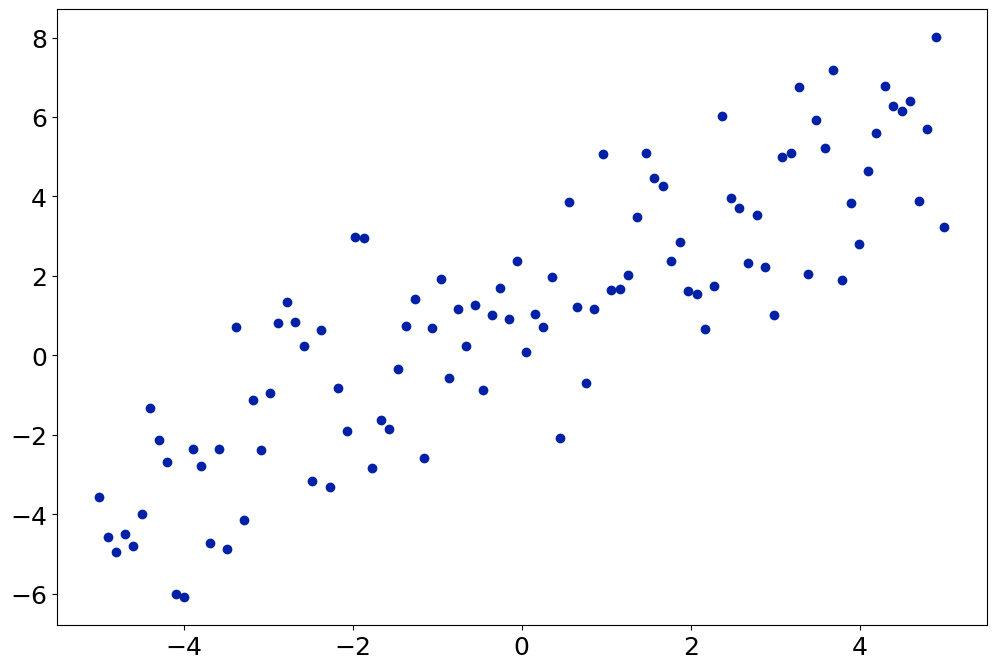

In [12]:
epsilon = 2.0

support_vector_regression = LinearSVR(epsilon=epsilon, C=0.01, fit_intercept=True)
support_vector_regression.fit(X_train, y_train)

svr_results(y_test, X_test, model=support_vector_regression, epsilon=epsilon)

When we increase $C$, the number of points outside the error margins decreases.

In [ ]:
epsilon = 2.0

support_vector_regression = LinearSVR(epsilon=epsilon, C=1.0, fit_intercept=True)
support_vector_regression.fit(X_train, y_train)

svr_results(y_test, X_test, model=support_vector_regression, epsilon=epsilon)

We vary the hyperparameter $C$ to obtain an optimal value minimizing the deviations.

In [ ]:
test_mae_list = []
percentage_within_epsilon_list = []

epsilon = 2.0
c_values = np.linspace(0.01, 1, num=100)

for c in c_values:
    varied_svr = LinearSVR(epsilon=epsilon, C=c, fit_intercept=True, max_iter=10000)
    
    varied_svr.fit(X_train, y_train)

    test_mae = mean_absolute_error( y_test, varied_svr.predict(X_test) )
    test_mae_list.append(test_mae)
    
    within_epsilon            = np.sum( abs( y_test - varied_svr.predict(X_test) ) <= epsilon )

    percentage_within_epsilon = 100*within_epsilon/y_test.size
    percentage_within_epsilon_list.append(percentage_within_epsilon)

fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('C', fontsize=18)
ax1.set_ylabel('% within Epsilon', color=orange, fontsize=18)

ax1.scatter(c_values, percentage_within_epsilon_list, color=orange)

ax1.tick_params(axis='y', labelcolor=orange)

ax2 = ax1.twinx()

ax2.set_ylabel('Test MAE', color=blue, fontsize=18)

ax2.scatter(c_values, test_mae_list, color=blue)

ax2.tick_params(axis='y', labelcolor=blue)

plt.show()

Here, the resulting model closely matches linear regression. Support Vector Regression becomes very powerful for large datasets and when using a kernel instead of linear regression.

**Compared to Kernel Ridge Regression, Support Vector Regression learns a sparse model and becomes faster for large datasets.**

Now let's see a more challenging test case

In [ ]:
data = datasets.load_iris()

x = data.data[:,:2]
y = data.target

# Plot data

fig, ax = plt.subplots( figsize=(8,8) )

scatter = plt.scatter(x[:,0], x[:,1], c=y, label=y, cmap=plt.cm.viridis, edgecolors='k')

plt.title('Clustered data', fontsize=20)

plt.xlabel(r'$x_0$', fontsize=18)
plt.ylabel(r'$x_1$', fontsize=18)

handles, _ = scatter.legend_elements()

plt.legend(handles=handles, labels=['Insulator', 'Conductor', 'Semiconductor'], loc='best', fontsize=18)

plt.show()

In [ ]:
# Train the classifier
def support_vector_classifier(x, y, kernel='linear', regularization=1.0, gamma=1e-2, points=300):
    
    # Create the classifier
    support_vector_machine = svm.SVC(kernel=kernel, C=regularization, gamma=gamma)

    support_vector_machine.fit(x, y)

    # Create a mesh
    x_mesh, y_mesh = np.meshgrid( np.linspace(x[:,0].min()-1.0, x[:,0].max()+1.0, num=points),
                                  np.linspace(x[:,1].min()-1.0, x[:,1].max()+1.0, num=points) )
    
    # stack X and y column-wise
    xy = np.column_stack( [np.ravel(x_mesh), np.ravel(y_mesh)] )

    z_mesh = support_vector_machine.predict(xy)

    z_mesh = z_mesh.reshape(x_mesh.shape)

    return x_mesh, y_mesh, z_mesh, support_vector_machine

# Plot classification regions
def plot_classifier(x, y, x_mesh, y_mesh, z_mesh, text=None):

    fig, ax = plt.subplots( figsize=(8,8) )

    ax.contourf(x_mesh, y_mesh, z_mesh, cmap=plt.cm.viridis, alpha=0.3)

    scatter = plt.scatter(x[:,0], x[:,1], c=y, label=y, cmap=plt.cm.viridis, edgecolors='k')

    plt.title('Clustered data', fontsize=20)

    plt.xlabel(r'$x_0$', fontsize=18)
    plt.ylabel(r'$x_1$', fontsize=18)

    handles, _ = scatter.legend_elements()

    plt.legend(handles=handles, labels=['Insulator', 'Conductor', 'Semiconductor'], loc='lower right', fontsize=18)

    if text:
        plt.text(0.05, 0.90, text, transform=ax.transAxes, fontsize=18)

    plt.show()

In [ ]:
# Regularization parameter
C = 1.0

# Divide data into 80% for training and 20% for testing
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=12)

# Train the classifier
x_mesh, y_mesh, z_mesh, svm_classifier = support_vector_classifier(x_train, y_train, regularization=C)

# Evaluate the classifier
accuracy = svm_classifier.score(x_test, y_test)

# Plot data
plot_classifier(x, y, x_mesh, y_mesh, z_mesh, text=f'Accuracy = {100.0*accuracy:.2f} %')

> ### Assignment
>
> - Optimize the regularization parameter for the SVM classifier. 
> - Plot the classification regions for that optimum value.

So far we only discused the linear kernel, but `sklearn` also provides other kernels. Let's see how the Radial Basis Function (RBF) kernel performs. The main characteristic of this kernel is that we can define a region where a point influences another point in the set. It's value often is seen as the inverse of this influence radius.

In [ ]:
# Regularization parameter
C = 1.0

x_mesh, y_mesh, z_mesh, svm_classifier = support_vector_classifier(x_train, y_train, kernel='rbf', regularization=C, gamma=1.0)

# Evaluate the classifier
accuracy = svm_classifier.score(x_test, y_test)

# Plot data
plot_classifier(x, y, x_mesh, y_mesh, z_mesh, text=f'Accuracy = {100.0*accuracy:.2f}')

We can visualize the effects of both $C$ and $\gamma$ on the classification

In [ ]:
C_values     = [0.01, 1.0, 10.0]
gamma_values = [0.01, 10.0, 100.0]

rows, cols   = 3, 3

fig, ax      = plt.subplots(nrows=rows, ncols=cols, figsize=(8,8), layout='tight')

for row in range(rows):
    for col in range(cols):
        
        x_mesh, y_mesh, z_mesh, _ = support_vector_classifier(x_train, y_train, kernel='rbf',
                                                              regularization=C_values[row], gamma=gamma_values[col])

        ax[row,col].contourf(x_mesh, y_mesh, z_mesh, cmap=plt.cm.viridis, alpha=0.3)

        ax[row,col].scatter(x[:,0], x[:,1], c=y, label=y, cmap=plt.cm.viridis, edgecolors='k')

        ax[row,col].set_title(r'$C$ = {}, $\gamma$ = {}'.format(C_values[row], gamma_values[col]), fontsize=18)

        ax[row,col].set_xlabel(None)
        ax[row,col].set_ylabel(None)

        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])

plt.show()

We can see clearly that the choice of the regularization parameter $C$ and the kernel parameter $\gamma$ are very important for the performance of the classifier.
    
> ### Assignment
>
> use a grid search to find the best parameters for the classifier. And plot the result